# Sistemas de recomendación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
user = pd.read_csv('demo_11_dataset/BX-Users.csv', sep=';', encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('demo_11_dataset/BX-Book-Ratings.csv', sep=';', encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


Veamos la distribución de las valoraciones

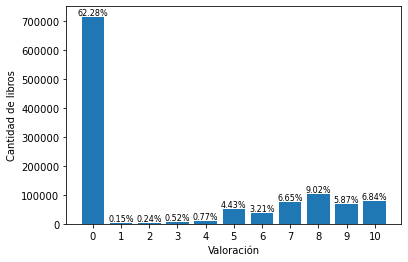

In [4]:
data = df['bookRating'].value_counts().sort_index(ascending=False)

p1 = plt.bar(data.index,data.values)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( f"{height/data.values.sum()*100:.2f}%",(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)

plt.xticks(np.arange(0,11,1))
plt.ylabel('Cantidad de libros')
plt.xlabel('Valoración')
plt.show()

Veamos cómo es la distribución de número de valoraciones por libro

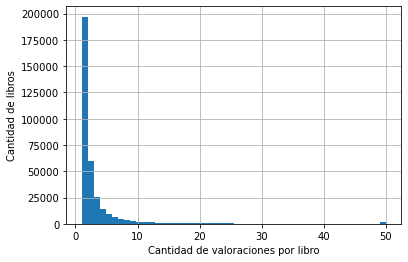

In [5]:
data = df.groupby('ISBN')['bookRating'].count()

data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por libro')
plt.ylabel('Cantidad de libros')
plt.show()

In [6]:
# Los 10 libros más votados
data.sort_values(ascending=False)[:10]

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: bookRating, dtype: int64

Ahora podemos pensar en al distribución de cantidad de valoraciones por usuario

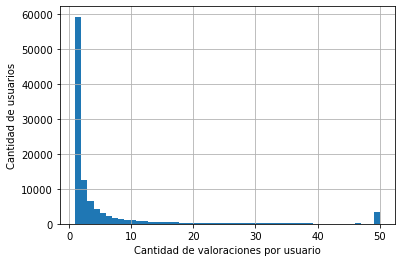

In [7]:
data = df.groupby('userID')['bookRating'].count()
data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por usuario')
plt.ylabel('Cantidad de usuarios')
plt.show()

La mayoria de los usuarios dan menos de 10 valoraciones. Cuántas valoraciones dio el usuario más activo?

In [8]:
df

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0
...,...,...,...
1149775,278854,0425163393,7
1149776,278854,0515087122,0
1149777,278854,0553275739,6
1149778,278854,0553578596,0


In [9]:
df.groupby('userID')['bookRating'].count().sort_values(ascending=False)[:5]

userID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: bookRating, dtype: int64

Tanto el número de valoraciones por libro y el número de valoraciones por usuario tienen distribuciones que decaen exponencialmente!

Para evitar problemas de memoria, vamos a filtrar los libros y los usuarios "outlayers". 

In [10]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


Armamos un array booleano que nos indica cuáles ISBN's cumplen con la condición lógica de al menos tener 50 ratings

In [11]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books

0971880107     True
0316666343     True
0385504209     True
0060928336     True
0312195516     True
              ...  
0916211223    False
0916211231    False
0916211274    False
0916211282    False
1569661057    False
Name: ISBN, Length: 340556, dtype: bool

Luego, nos quedamos sólo con los que los cumplen

In [12]:
filter_books = filter_books[filter_books].index.tolist()
filter_books

['0971880107',
 '0316666343',
 '0385504209',
 '0060928336',
 '0312195516',
 '044023722X',
 '0679781587',
 '0142001740',
 '067976402X',
 '0671027360',
 '0446672211',
 '059035342X',
 '0316601950',
 '0375727345',
 '044021145X',
 '0452282152',
 '0440214041',
 '0804106304',
 '0440211727',
 '0345337662',
 '0060930535',
 '0440226430',
 '0312278586',
 '0743418174',
 '0671021001',
 '0345370775',
 '0446605239',
 '0156027321',
 '0440241073',
 '0671003755',
 '0060976845',
 '1400034779',
 '0786868716',
 '0440234743',
 '0440222656',
 '0440221471',
 '0345361792',
 '0440236673',
 '0345417623',
 '0316769487',
 '0446610038',
 '0385484518',
 '0446310786',
 '044022165X',
 '0375706771',
 '0440225701',
 '0440220602',
 '0060502258',
 '0446606812',
 '0345353145',
 '044651652X',
 '0140293248',
 '0345443284',
 '0440206154',
 '0440213525',
 '006101351X',
 '0316284955',
 '0312291639',
 '0375707972',
 '0439064872',
 '0060934417',
 '0385335482',
 '0671510053',
 '0440224764',
 '0452282829',
 '0385492081',
 '06848447

In [13]:
condicion1 = (df['ISBN'].isin(filter_books))
df[condicion1]['ISBN'].value_counts()

0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
              ... 
0812513711      51
0671020293      51
0670896764      51
0394281802      51
0446613053      51
Name: ISBN, Length: 2125, dtype: int64

Hacemos lo mismo con los usuarios

In [14]:
min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()
condicion2 = (df['userID'].isin(filter_users))
df_new = df[(condicion2 & condicion1)]

## Búsqueda del mejor modelo 

In [15]:
reader = Reader(rating_scale=(1, 10)) # 0 = N/A
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

benchmark = []
# Iterate over all algorithms
for i, algorithm in enumerate([SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), #SVDpp
                 KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]):
    # Perform cross validation
    print(i)
    try:
        results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
            # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
    except:
        continue


0


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


1


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


2
3


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


4
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


6
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


7
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


8
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


9


C:\Users\jo_ro\AppData\Local\Temp\ipykernel_14468\3182798537.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


[Overview](https://www.kdnuggets.com/2017/08/recommendation-system-algorithms-overview.html) de los algoritmos

Algunos:

- NormalPredictor : $\hat{r}_{ui}$ se muestrea de una distribución gaussiana con media $\hat{\mu}$ y desvío $\hat{\sigma}^2$ obtenidos por máxima verosimilitud utilizando los datos de entrenamiento.

- [BaselineOnly](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration) : $\hat{r}_{ui} = \mu + b_u + b_i$

- [kNNBasic](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration) : $\hat{r}_{ui} = \frac{\sum_{v \in vecinos}sim(u,v) \cdot r_{vi}}{\sum_{v \in vecinos} sim(u,v)}$

- [Matrix factorization](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) : $\hat{r}_{ui} = \mu + b_u + b_i + q_i^T p_u$ (si $\mu$, $b_u$ y $b_i$ son 0 se llama Probabilistic Matrix Factorization)

In [16]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.386104,0.452497,0.536235
CoClustering,3.459549,4.353557,0.486924
SlopeOne,3.465736,0.823736,3.513434
KNNWithMeans,3.482464,1.360759,7.021093
KNNBaseline,3.493899,1.346840,7.074138
KNNWithZScore,3.511021,1.546067,7.113485
SVD,3.522302,6.951171,0.494526
KNNBasic,3.683371,1.285020,7.563914
NormalPredictor,4.584930,0.161787,0.348064


## Selección de modelo y selección de hiperparámetros

Nos quedamos con el algoritmo `BaselineOnly()`. Además vamos a utilizar el método [Alternating Least Squares](https://sophwats.github.io/2018-04-05-gentle-als.html) para encontrar los $b_u$ y $b_i$

In [17]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.3970799 , 3.37875857, 3.38626509]),
 'fit_time': (0.25597310066223145, 0.27899861335754395, 0.28099536895751953),
 'test_time': (0.5840184688568115, 0.6380066871643066, 0.695002555847168)}

In [18]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)

Estimating biases using als...


## Analizando los resultados

In [19]:
predictions

[Prediction(uid=264082, iid='0425155404', r_ui=0.0, est=3.745675756824423, details={'was_impossible': False}),
 Prediction(uid=97874, iid='0316666343', r_ui=9.0, est=6.951137380245688, details={'was_impossible': False}),
 Prediction(uid=94923, iid='0345362861', r_ui=0.0, est=2.206451881513029, details={'was_impossible': False}),
 Prediction(uid=250184, iid='0061097101', r_ui=7.0, est=1, details={'was_impossible': False}),
 Prediction(uid=91931, iid='0316666343', r_ui=0.0, est=2.235140561973643, details={'was_impossible': False}),
 Prediction(uid=6563, iid='034541389X', r_ui=0.0, est=1.7288898139772577, details={'was_impossible': False}),
 Prediction(uid=180651, iid='0060502258', r_ui=2.0, est=2.4572345018448103, details={'was_impossible': False}),
 Prediction(uid=82164, iid='0446605239', r_ui=7.0, est=2.230685478377648, details={'was_impossible': False}),
 Prediction(uid=181176, iid='0679723161', r_ui=0.0, est=2.511961042526629, details={'was_impossible': False}),
 Prediction(uid=20396

In [20]:
accuracy.rmse(predictions)

RMSE: 3.3817


3.3816802948231004

In [21]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


In [22]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [23]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,264082,0425155404,0.0,3.745676,{'was_impossible': False},57,65,3.745676
1,97874,0316666343,9.0,6.951137,{'was_impossible': False},21,415,2.048863
2,94923,0345362861,0.0,2.206452,{'was_impossible': False},42,39,2.206452
3,250184,0061097101,7.0,1.000000,{'was_impossible': False},93,92,6.000000
4,91931,0316666343,0.0,2.235141,{'was_impossible': False},46,415,2.235141


Podemos guardar las mejores y peores predicciones

In [24]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [25]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
24981,186570,0345422406,1.0,1.000000,{'was_impossible': False},116,24,0.000000
17200,251422,0971880107,1.0,1.000000,{'was_impossible': False},111,653,0.000000
12007,123883,0553278274,5.0,4.999592,{'was_impossible': False},59,36,0.000408
7627,96448,0380702843,5.0,5.000522,{'was_impossible': False},17,28,0.000522
31620,98391,0316666343,9.0,9.000562,{'was_impossible': False},75,415,0.000562
7743,253871,051511992X,6.0,5.996505,{'was_impossible': False},28,60,0.003495
21851,136491,0439139597,8.0,7.991152,{'was_impossible': False},32,87,0.008848
30042,69078,0743418174,6.0,5.989907,{'was_impossible': False},73,200,0.010093
26916,134434,0345339711,6.0,6.010247,{'was_impossible': False},26,75,0.010247
31261,80642,0451167317,3.0,2.988691,{'was_impossible': False},14,76,0.011309


In [26]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2253,78783,0425147622,10.0,1.0,{'was_impossible': False},373,106,9.0
132,186570,0671789422,10.0,1.0,{'was_impossible': False},116,36,9.0
20606,78834,0743224574,10.0,1.0,{'was_impossible': False},154,71,9.0
8051,63938,0060391626,10.0,1.0,{'was_impossible': False},74,69,9.0
6293,73394,0553801341,10.0,1.0,{'was_impossible': False},235,24,9.0
22396,153563,0446604658,10.0,1.0,{'was_impossible': False},21,38,9.0
32918,251422,0684801469,10.0,1.0,{'was_impossible': False},111,19,9.0
6189,147965,0345409876,10.0,1.0,{'was_impossible': False},47,32,9.0
11995,212645,0441005489,10.0,1.0,{'was_impossible': False},41,36,9.0
22649,179733,0767905202,10.0,1.0,{'was_impossible': False},104,37,9.0


Qué está pasando con esos casos?

In [27]:
book = '0590353403'
df_new.loc[df_new['ISBN'] == book]['bookRating'].describe()

count    102.000000
mean       6.460784
std        4.251200
min        0.000000
25%        0.000000
50%        8.000000
75%       10.000000
max       10.000000
Name: bookRating, dtype: float64

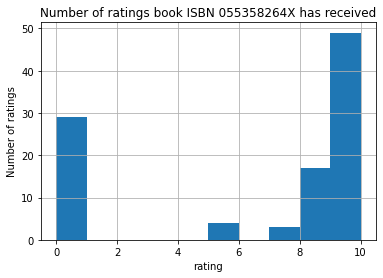

In [28]:
df_new.loc[df_new['ISBN'] == book]['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show()

Ejemplo extraído de [acá](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb)